In [1]:
import os
import itertools
import matplotlib

import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow.keras.backend as K

from tqdm import tqdm
from scipy.spatial import distance

In [2]:
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

In [3]:
np.random.seed(0)

In [4]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()

x_train = x_train / 255.
x_test = x_test / 255.

y_train = tf.keras.utils.to_categorical(y_train, 10)
y_test = tf.keras.utils.to_categorical(y_test, 10)

y_train = np.argmax(y_train, axis=1)

order = np.random.permutation(len(x_train))

x_train = x_train[order]
y_train = y_train[order]


y_train = tf.keras.utils.to_categorical(y_train, 10)

x_train_reshape = [x_train[i].reshape((784)) for i in range(len(x_train))]
print(np.array(x_train_reshape).shape)

x_test_reshape = [x_test[i].reshape((784)) for i in range(len(x_test))]
print(np.array(x_test_reshape).shape)

(60000, 784)
(10000, 784)


In [5]:
n_hidden_neurons = 64
lr = 0.001
epochs = 200
batch_size = 8
limit = 4096 # number of training examples to use.
alpha = 0.0 # penalise polysemantic neurons.

In [6]:
assert (limit % 8 == 0)

In [7]:
i = tf.keras.layers.Input(shape=(28*28,))
i2 = tf.keras.layers.Input(shape=(10,))
e1 = tf.keras.layers.Dense(n_hidden_neurons, activation='relu', name='dense_1')(i)
e2 = tf.keras.layers.Dense(n_hidden_neurons, activation='relu', name='dense_2')(e1)
o = tf.keras.layers.Dense(10, activation='softmax', name='softmax')(e2)
model = tf.keras.Model(inputs=[i, i2], outputs=o)

2022-05-24 22:57:49.120083: I tensorflow/core/platform/cpu_feature_guard.cc:142] Your CPU supports instructions that this TensorFlow binary was not compiled to use: AVX2 FMA
2022-05-24 22:57:49.138342: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x7fdd6809e8d0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2022-05-24 22:57:49.138365: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version


### define polysemantic loss

In [8]:
def calculate_term(e, c0, c1):
    a = K.expand_dims(e[c0] / (K.max(K.abs(e[c0])) + 1e-9))
    b = K.expand_dims(e[c1] / (K.max(K.abs(e[c1])) + 1e-9))
    return K.dot(K.transpose(a), b)

In [9]:
#https://stackoverflow.com/questions/62454500/how-to-use-tensorflow-custom-loss-for-a-keras-model
def my_loss(y_true, y_pred, e1, e2, c0, c1, alpha):
    p_loss = 0
    for i in range(len(c0)):
        p_loss += (1. - (tf.cast(tf.equal(K.argmax(y_true[c0[i]]), K.argmax(y_true[c1[i]])), dtype='float32'))) \
               * calculate_term(e1, c0[i], c1[i])
        p_loss += (1. - (tf.cast(tf.equal(K.argmax(y_true[c0[i]]), K.argmax(y_true[c1[i]])), dtype='float32'))) \
               * calculate_term(e2, c0[i], c1[i])
        
    loss = tf.keras.losses.CategoricalCrossentropy(from_logits=False)(y_true=y_true, 
                                                                      y_pred=y_pred)
    loss += alpha * (p_loss / len(c0))
    return loss

### precalculate all indices for batch_size choose 2 pairs

In [10]:
c0, c1 = [], []
for c in list(itertools.combinations(range(batch_size), 2)):
    c0.append(c[0])
    c1.append(c[1])

In [11]:
print(len(c0))

28


In [12]:
model.add_loss(my_loss(i2, o, e1, e2, np.array(c0, dtype='int32'), np.array(c1, dtype='int32'), alpha))

In [13]:
def my_acc(y_true, y_pred):
    y_pred = tf.cast(tf.math.greater(y_pred, tf.constant([0.5])), dtype='float32')
    return tf.cast(tf.math.equal(y_true, y_pred), dtype='float32')

def cce(y_true, y_pred):
    return tf.keras.losses.CategoricalCrossentropy(
        from_logits=False,
        reduction=tf.keras.losses.Reduction.NONE
    )(y_true=y_true, y_pred=y_pred)

def ps_term(y_true, e, c0, c1):
    p_loss = []
    for i in range(len(c0)):
        p_loss.append((1. - (tf.cast(tf.equal(K.argmax(y_true[c0[i]]), K.argmax(y_true[c1[i]])), dtype='float32'))) \
                       * calculate_term(e, c0[i], c1[i]))
    return tf.convert_to_tensor(p_loss)
    
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=lr), 
              loss=None)

model.add_metric(my_acc(i2, o), name='acc', aggregation='mean')
model.add_metric(cce(i2, o), name='cce', aggregation='mean')
model.add_metric(ps_term(i2, e1, c0, c1), name='ps1', aggregation='mean')
model.add_metric(ps_term(i2, e2, c0, c1), name='ps2', aggregation='mean')

In [14]:
# class CustomCallback(tf.keras.callbacks.Callback):
#     def __init__(self, n_hidden_neurons, save_path='./'):
#         self.n_hidden_neurons = n_hidden_neurons
#         self.save_path = save_path
        
#     def on_epoch_begin(self, epoch, logs=None):
#         W = self.model.layers[1].get_weights()
#         fig = plt.figure(figsize=(20,20))
#         dim = int(np.ceil(np.sqrt(64)))
#         for j in range(64):
#             x_j = W[0][:,j] / np.sqrt(np.sum(np.dot(W[0][:,j], W[0][:,j].T)))
#             ax = fig.add_subplot(dim,dim,j+1)
#             ax.imshow(x_j.reshape((28,28)))
#             plt.axis('off')
#         plt.savefig(os.path.join(self.save_path, '{}.png'.format(epoch)), bbox_inches='tight')
#         plt.close('all')

In [15]:
history = model.fit([np.array(x_train_reshape)[:limit], y_train[:limit]],
                    y=None,
                    validation_data=([np.array(x_train_reshape)[limit:limit+(limit//2)], 
                                     y_train[limit:limit+(limit//2)]], None),
                    batch_size=batch_size,
                    epochs=epochs)
#                     callbacks=[CustomCallback(n_hidden_neurons, '../video')])

Train on 4096 samples, validate on 2048 samples
Epoch 1/200
4096/4096 [==============================] - 71s 17ms/sample - loss: 0.6148 - acc: 0.9655 - cce: 0.6148 - ps1: 4.8386 - ps2: 5.3709 - val_loss: 0.3426 - val_acc: 0.9792 - val_cce: 0.3426 - val_ps1: 4.5615 - val_ps2: 5.0007
Epoch 2/200
4096/4096 [==============================] - 53s 13ms/sample - loss: 0.2665 - acc: 0.9840 - cce: 0.2665 - ps1: 4.2474 - ps2: 4.8078 - val_loss: 0.2595 - val_acc: 0.9850 - val_cce: 0.2595 - val_ps1: 4.0908 - val_ps2: 4.7679
Epoch 3/200
4096/4096 [==============================] - 55s 13ms/sample - loss: 0.1783 - acc: 0.9889 - cce: 0.1783 - ps1: 3.8907 - ps2: 4.6333 - val_loss: 0.2657 - val_acc: 0.9842 - val_cce: 0.2657 - val_ps1: 3.3929 - val_ps2: 4.0747
Epoch 4/200
4096/4096 [==============================] - 53s 13ms/sample - loss: 0.1206 - acc: 0.9924 - cce: 0.1206 - ps1: 3.7230 - ps2: 4.3225 - val_loss: 0.2436 - val_acc: 0.9859 - val_cce: 0.2436 - val_ps1: 3.5303 - val_ps2: 4.3552
Epoch 5/200


Epoch 35/200
4096/4096 [==============================] - 63s 15ms/sample - loss: 6.0722e-06 - acc: 1.0000 - cce: 6.0722e-06 - ps1: 3.7424 - ps2: 4.7474 - val_loss: 0.3704 - val_acc: 0.9896 - val_cce: 0.3704 - val_ps1: 3.6928 - val_ps2: 4.8224
Epoch 36/200
4096/4096 [==============================] - 66s 16ms/sample - loss: 4.9354e-06 - acc: 1.0000 - cce: 4.9354e-06 - ps1: 3.7734 - ps2: 4.8198 - val_loss: 0.3813 - val_acc: 0.9896 - val_cce: 0.3813 - val_ps1: 3.7369 - val_ps2: 4.8479
Epoch 37/200
4096/4096 [==============================] - 56s 14ms/sample - loss: 3.5765e-06 - acc: 1.0000 - cce: 3.5765e-06 - ps1: 3.7857 - ps2: 4.8359 - val_loss: 0.3867 - val_acc: 0.9895 - val_cce: 0.3867 - val_ps1: 3.7958 - val_ps2: 4.9300
Epoch 38/200
4096/4096 [==============================] - 60s 15ms/sample - loss: 2.8908e-06 - acc: 1.0000 - cce: 2.8908e-06 - ps1: 3.7772 - ps2: 4.8059 - val_loss: 0.3869 - val_acc: 0.9896 - val_cce: 0.3869 - val_ps1: 3.7910 - val_ps2: 4.9168
Epoch 39/200
4096/4096 [

Epoch 69/200
4096/4096 [==============================] - 55s 14ms/sample - loss: 8.5212e-07 - acc: 1.0000 - cce: 8.5212e-07 - ps1: 2.6679 - ps2: 3.9399 - val_loss: 0.4442 - val_acc: 0.9896 - val_cce: 0.4442 - val_ps1: 2.6674 - val_ps2: 3.9857
Epoch 70/200
4096/4096 [==============================] - 56s 14ms/sample - loss: 7.0199e-07 - acc: 1.0000 - cce: 7.0199e-07 - ps1: 2.6708 - ps2: 3.9541 - val_loss: 0.4500 - val_acc: 0.9895 - val_cce: 0.4500 - val_ps1: 2.7132 - val_ps2: 4.0483
Epoch 71/200
4096/4096 [==============================] - 56s 14ms/sample - loss: 5.8003e-07 - acc: 1.0000 - cce: 5.8003e-07 - ps1: 2.7189 - ps2: 4.0081 - val_loss: 0.4537 - val_acc: 0.9894 - val_cce: 0.4537 - val_ps1: 2.7397 - val_ps2: 4.0859
Epoch 72/200
4096/4096 [==============================] - 55s 13ms/sample - loss: 4.7856e-07 - acc: 1.0000 - cce: 4.7856e-07 - ps1: 2.7267 - ps2: 4.0146 - val_loss: 0.4547 - val_acc: 0.9896 - val_cce: 0.4547 - val_ps1: 2.7597 - val_ps2: 4.1153
Epoch 73/200
4096/4096 [

4096/4096 [==============================] - 60s 15ms/sample - loss: 1.1921e-07 - acc: 1.0000 - cce: 1.1921e-07 - ps1: 3.0625 - ps2: 4.5233 - val_loss: 0.4902 - val_acc: 0.9900 - val_cce: 0.4902 - val_ps1: 3.0780 - val_ps2: 4.6069
Epoch 103/200
4096/4096 [==============================] - 61s 15ms/sample - loss: 1.1921e-07 - acc: 1.0000 - cce: 1.1921e-07 - ps1: 3.0865 - ps2: 4.5528 - val_loss: 0.4918 - val_acc: 0.9898 - val_cce: 0.4918 - val_ps1: 3.0774 - val_ps2: 4.6078
Epoch 104/200
4096/4096 [==============================] - 63s 15ms/sample - loss: 1.1921e-07 - acc: 1.0000 - cce: 1.1921e-07 - ps1: 3.0751 - ps2: 4.5318 - val_loss: 0.4911 - val_acc: 0.9898 - val_cce: 0.4911 - val_ps1: 3.0772 - val_ps2: 4.6079
Epoch 105/200
4096/4096 [==============================] - 60s 15ms/sample - loss: 1.1921e-07 - acc: 1.0000 - cce: 1.1921e-07 - ps1: 3.0621 - ps2: 4.5197 - val_loss: 0.4911 - val_acc: 0.9898 - val_cce: 0.4911 - val_ps1: 3.0772 - val_ps2: 4.6079
Epoch 106/200
4096/4096 [=========

4096/4096 [==============================] - 53s 13ms/sample - loss: 1.1921e-07 - acc: 1.0000 - cce: 1.1921e-07 - ps1: 3.0670 - ps2: 4.5373 - val_loss: 0.4911 - val_acc: 0.9898 - val_cce: 0.4911 - val_ps1: 3.0772 - val_ps2: 4.6079
Epoch 136/200
4096/4096 [==============================] - 52s 13ms/sample - loss: 1.1921e-07 - acc: 1.0000 - cce: 1.1921e-07 - ps1: 3.0790 - ps2: 4.5412 - val_loss: 0.4911 - val_acc: 0.9898 - val_cce: 0.4911 - val_ps1: 3.0772 - val_ps2: 4.6079
Epoch 137/200
4096/4096 [==============================] - 53s 13ms/sample - loss: 1.1921e-07 - acc: 1.0000 - cce: 1.1921e-07 - ps1: 3.0744 - ps2: 4.5371 - val_loss: 0.4911 - val_acc: 0.9898 - val_cce: 0.4911 - val_ps1: 3.0772 - val_ps2: 4.6079
Epoch 138/200
4096/4096 [==============================] - 55s 13ms/sample - loss: 1.1921e-07 - acc: 1.0000 - cce: 1.1921e-07 - ps1: 3.0640 - ps2: 4.5258 - val_loss: 0.4911 - val_acc: 0.9898 - val_cce: 0.4911 - val_ps1: 3.0772 - val_ps2: 4.6079
Epoch 139/200
4096/4096 [=========

4096/4096 [==============================] - 53s 13ms/sample - loss: 1.1921e-07 - acc: 1.0000 - cce: 1.1921e-07 - ps1: 3.0672 - ps2: 4.5286 - val_loss: 0.4911 - val_acc: 0.9898 - val_cce: 0.4911 - val_ps1: 3.0772 - val_ps2: 4.6079
Epoch 169/200
4096/4096 [==============================] - 53s 13ms/sample - loss: 1.1921e-07 - acc: 1.0000 - cce: 1.1921e-07 - ps1: 3.0815 - ps2: 4.5608 - val_loss: 0.4911 - val_acc: 0.9898 - val_cce: 0.4911 - val_ps1: 3.0772 - val_ps2: 4.6079
Epoch 170/200
4096/4096 [==============================] - 53s 13ms/sample - loss: 1.1921e-07 - acc: 1.0000 - cce: 1.1921e-07 - ps1: 3.0653 - ps2: 4.5238 - val_loss: 0.4911 - val_acc: 0.9898 - val_cce: 0.4911 - val_ps1: 3.0772 - val_ps2: 4.6079
Epoch 171/200
4096/4096 [==============================] - 53s 13ms/sample - loss: 1.1921e-07 - acc: 1.0000 - cce: 1.1921e-07 - ps1: 3.0628 - ps2: 4.5046 - val_loss: 0.4911 - val_acc: 0.9898 - val_cce: 0.4911 - val_ps1: 3.0772 - val_ps2: 4.6079
Epoch 172/200
4096/4096 [=========

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


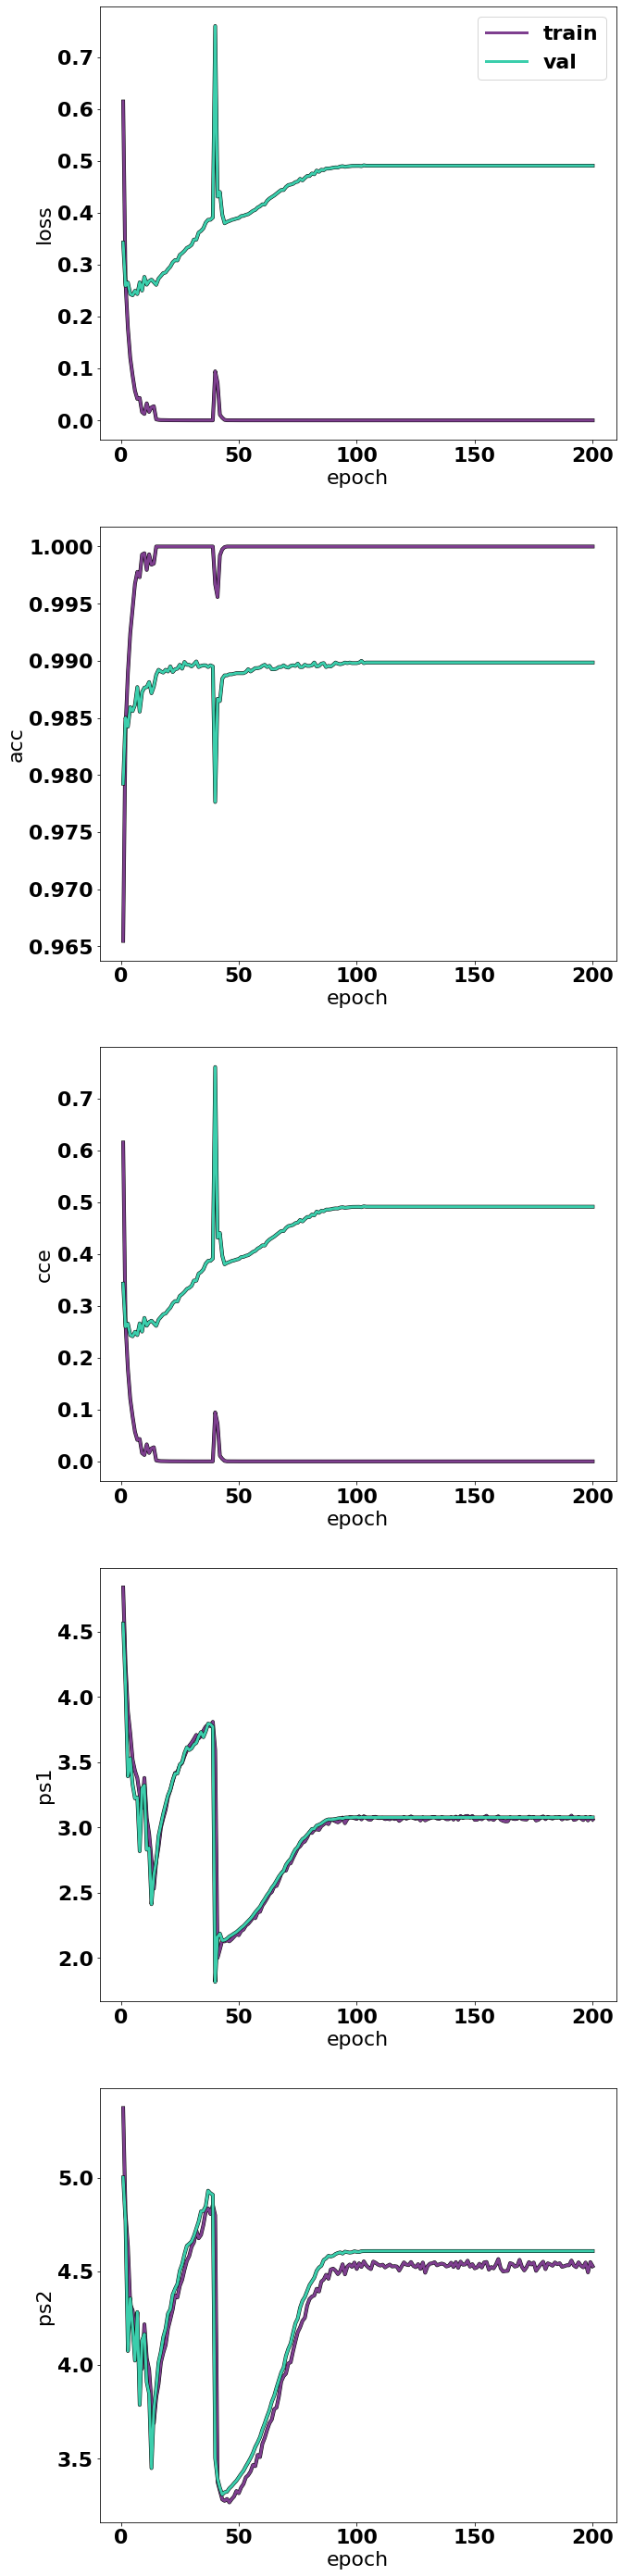

In [16]:
fig = plt.figure(figsize=(10,50))
for j,m in enumerate(['loss', 'acc', 'cce', 'ps1', 'ps2']):
    ax = fig.add_subplot(5,1,j+1)
    ax.plot(range(1,epochs+1), np.squeeze(history.history[m]), 'k-', lw=4)
    t, = ax.plot(range(1,epochs+1), np.squeeze(history.history[m]), '-', color='#7E3F8F', lw=3)
    ax.plot(range(1,epochs+1), np.squeeze(history.history['val_{}'.format(m)]), 'k-', lw=4)
    v, = ax.plot(range(1,epochs+1), np.squeeze(history.history['val_{}'.format(m)]), '-', color='#3BCEAC', lw=3)
    ax.set_ylabel(m)
    ax.set_xlabel('epoch')
    if j == 0:
        ax.legend([t, v], ['train', 'val'])

### calculate test set accuracy

In [17]:
inference = tf.keras.Model(inputs=i, outputs=o)
y_pred_test = inference.predict(np.array(x_test_reshape))
print(np.mean(my_acc(y_test, y_pred_test)))

0.98982


### calculate activations across the training set

In [18]:
embed1 = tf.keras.Model(inputs=i, outputs=e1)

In [19]:
embed1.layers[1].set_weights(model.layers[1].get_weights())
embed1_activations_by_class = {}
a = embed1.predict(np.array(x_train_reshape))
for j in tqdm(range(len(x_train_reshape[:limit]))):
    try:
        embed1_activations_by_class[np.argmax(y_train, axis=1)[j]] += np.squeeze(a[j])
    except KeyError:
        embed1_activations_by_class[np.argmax(y_train, axis=1)[j]] = np.squeeze(a[j])

100%|██████████████████████████████████████████████████████████████████████| 4096/4096 [00:04<00:00, 941.63it/s]


/Users/dwright/anaconda2/envs/polysemantic_neurons/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


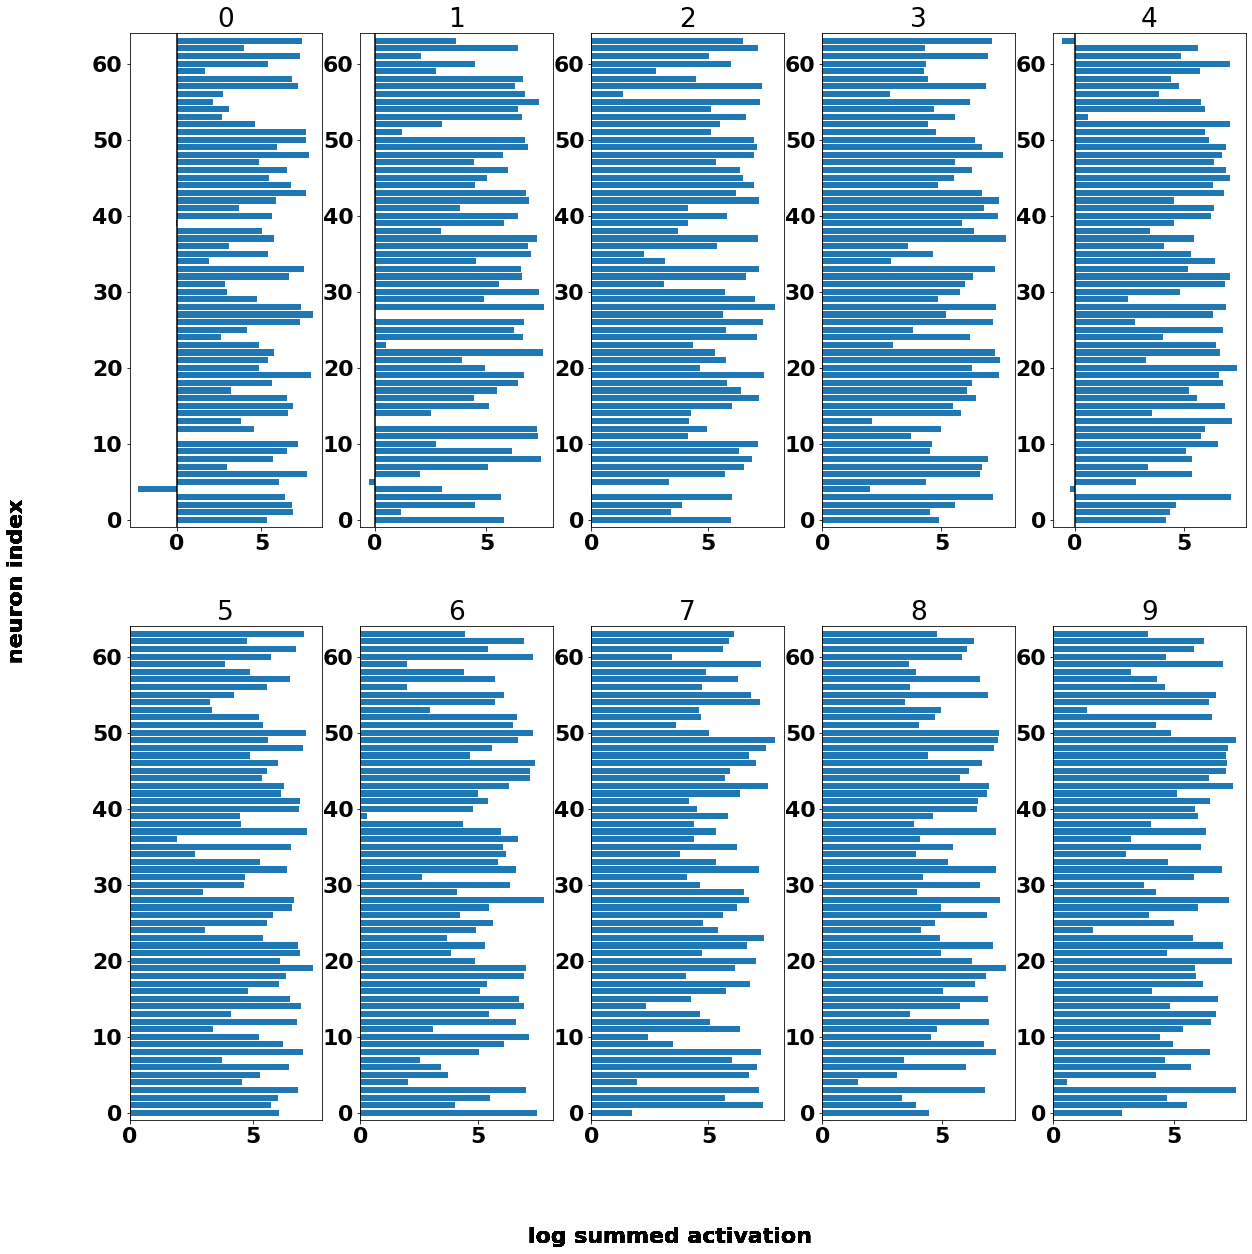

In [20]:
fig = plt.figure(figsize=(20,20))
classes = list(embed1_activations_by_class.keys())
classes.sort()
for i,k in enumerate(classes):
    y_pos = np.arange(len(embed1_activations_by_class[k]))
    ax = fig.add_subplot(2, 5, i+1)
    ax.set_title(k)
    ax.barh(y_pos, np.log(np.squeeze(embed1_activations_by_class[k])), align='center')
    ax.plot([0,0],[-1,len(np.squeeze(embed1_activations_by_class[k]))], 'k-')
    ax.set_ylim(-1,len(np.squeeze(embed1_activations_by_class[k])))
    fig.text(0.5, 0.04, 'log summed activation', ha='center')
    fig.text(0.04, 0.5, 'neuron index', va='center', rotation='vertical')

In [21]:
embed2_input = tf.keras.layers.Input(shape=(28*28,))
embed2_hidden1 = tf.keras.layers.Dense(n_hidden_neurons, activation='relu', name='embed2_hidden1')(embed2_input)
embed2_output = tf.keras.layers.Dense(n_hidden_neurons, activation='relu', name='embed2_output')(embed2_hidden1)
embed2 = tf.keras.Model(inputs=embed2_input, outputs=embed2_output)

In [22]:
embed2.layers[1].set_weights(model.layers[1].get_weights())
embed2.layers[2].set_weights(model.layers[2].get_weights())
embed2_activations_by_class = {}
a = embed2.predict(np.array(x_train_reshape))
for j in tqdm(range(len(x_train_reshape[:limit]))):
    try:
        embed2_activations_by_class[np.argmax(y_train, axis=1)[j]] += np.squeeze(a[j])
    except KeyError:
        embed2_activations_by_class[np.argmax(y_train, axis=1)[j]] = np.squeeze(a[j])

100%|██████████████████████████████████████████████████████████████████████| 4096/4096 [00:04<00:00, 912.48it/s]


/Users/dwright/anaconda2/envs/polysemantic_neurons/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  


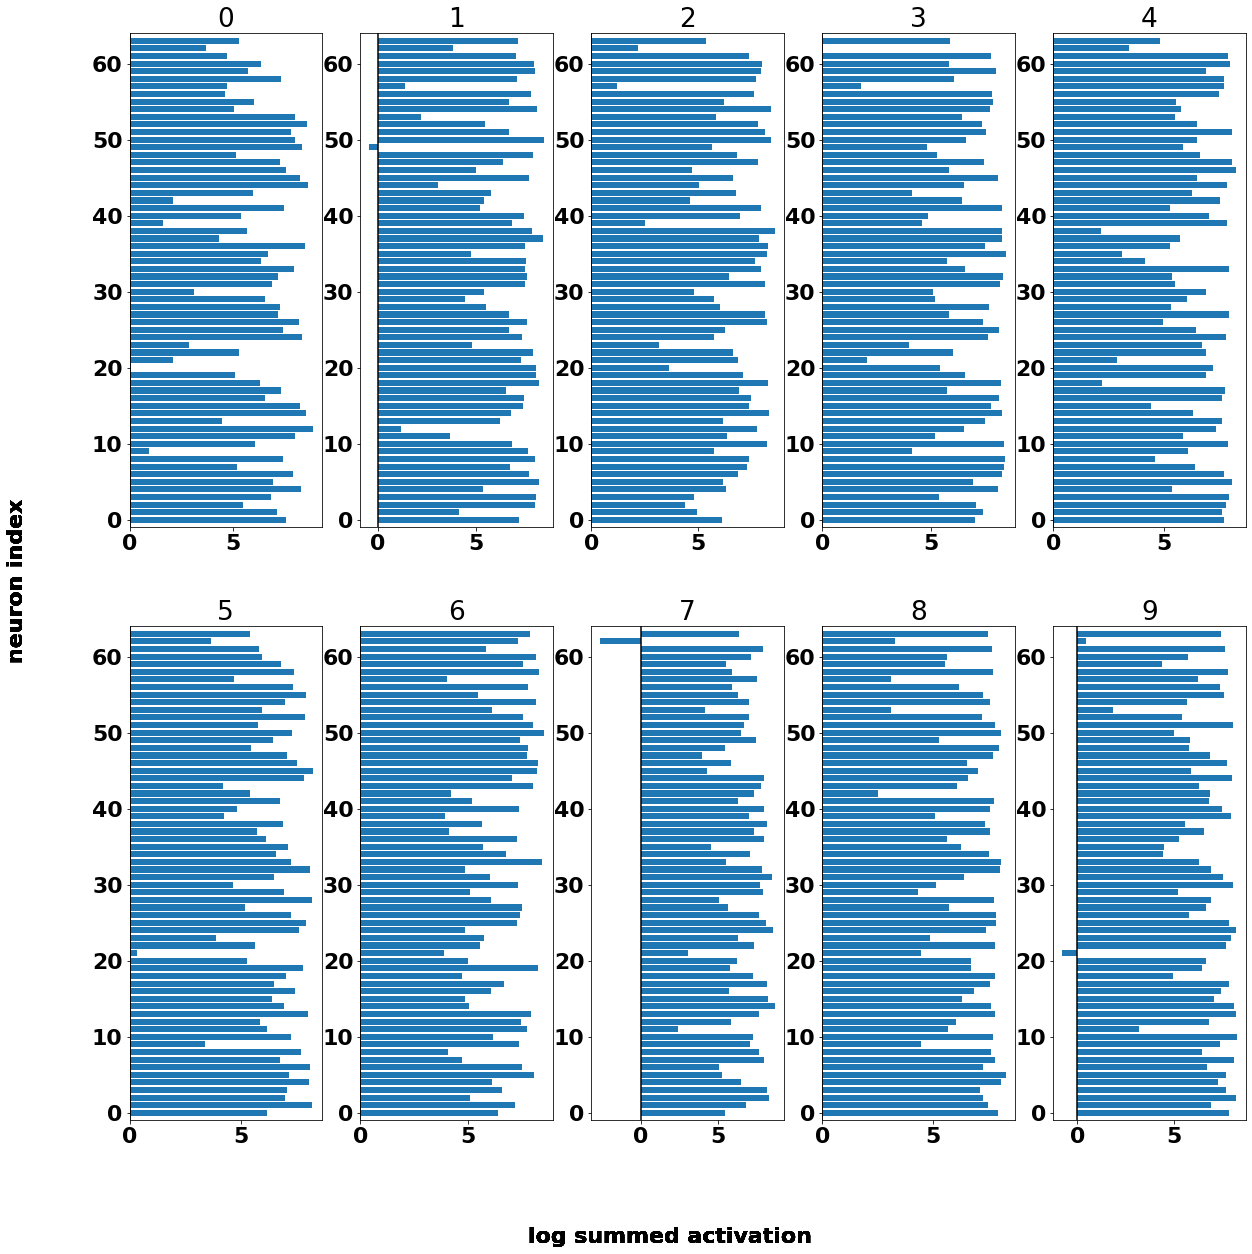

In [23]:
fig = plt.figure(figsize=(20,20))
classes = list(embed2_activations_by_class.keys())
classes.sort()
for i,k in enumerate(classes):
    y_pos = np.arange(len(embed2_activations_by_class[k]))
    ax = fig.add_subplot(2, 5, i+1)
    ax.set_title(k)
    ax.barh(y_pos, np.log(np.squeeze(embed2_activations_by_class[k])), align='center')
    ax.plot([0,0],[-1,len(np.squeeze(embed2_activations_by_class[k]))], 'k-')
    ax.set_ylim(-1,len(np.squeeze(embed2_activations_by_class[k])))
    fig.text(0.5, 0.04, 'log summed activation', ha='center')
    fig.text(0.04, 0.5, 'neuron index', va='center', rotation='vertical')

### calculate activations across the test set

In [24]:
embed1_activations_by_class_test = {}
a = embed1.predict(np.array(x_test_reshape))
for j in tqdm(range(len(x_test_reshape))):
    try:
        embed1_activations_by_class_test[np.argmax(y_test, axis=1)[j]] += np.squeeze(a[j])
    except KeyError:
        embed1_activations_by_class_test[np.argmax(y_test, axis=1)[j]] = np.squeeze(a[j])

100%|███████████████████████████████████████████████████████████████████| 10000/10000 [00:01<00:00, 5680.00it/s]


/Users/dwright/anaconda2/envs/polysemantic_neurons/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  


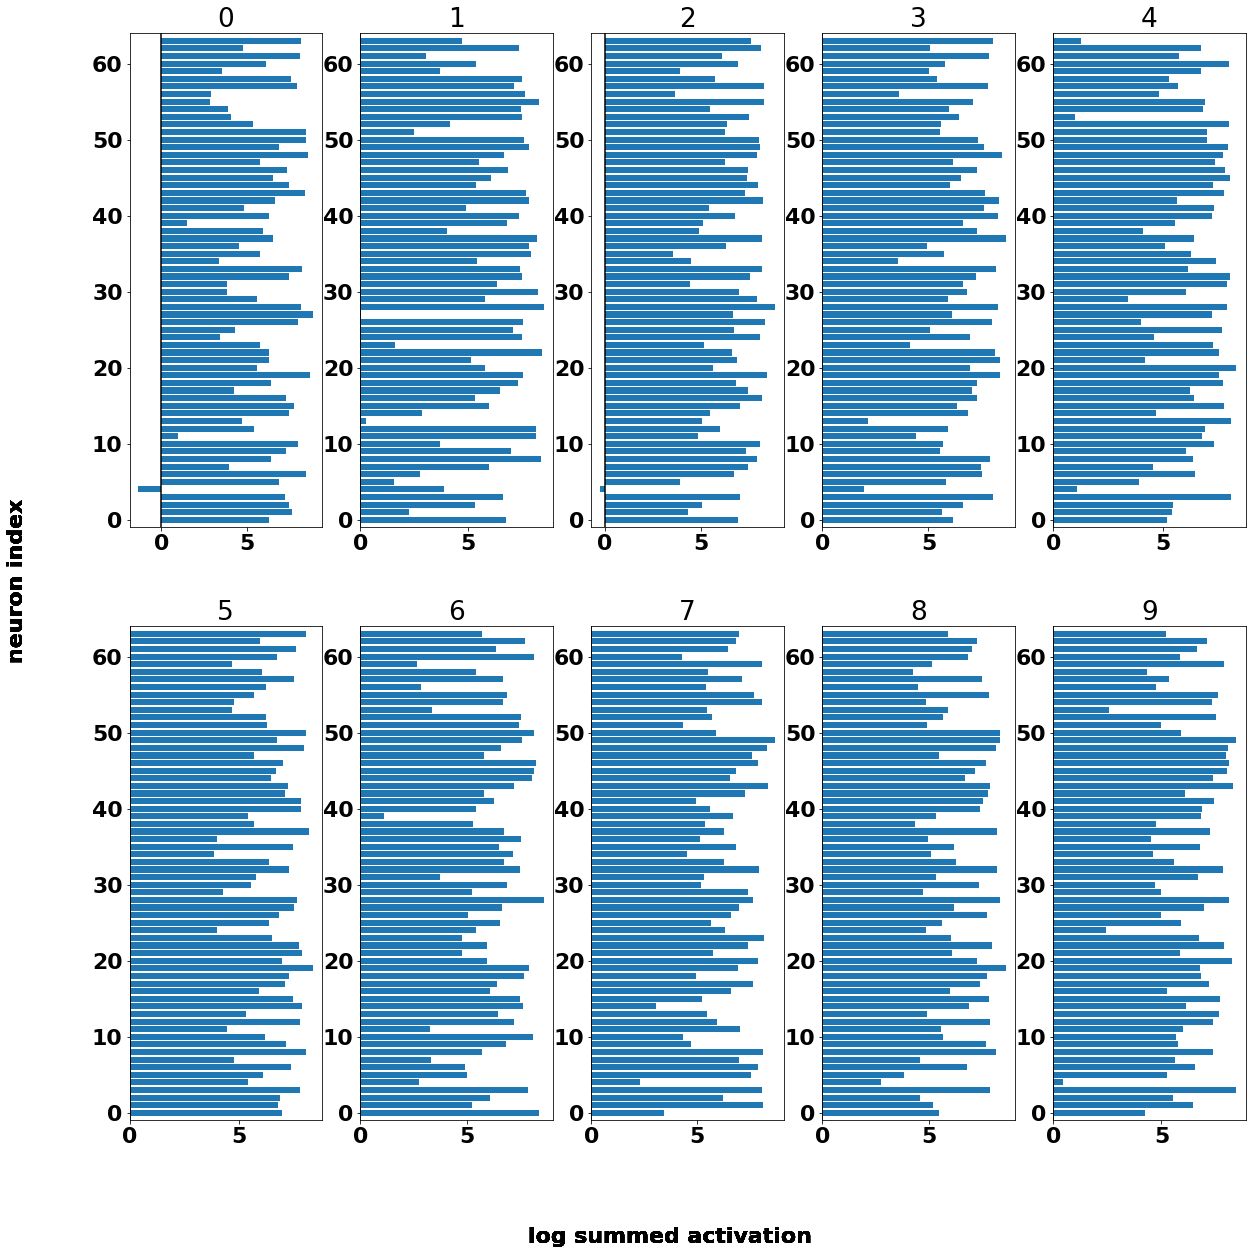

In [25]:
fig = plt.figure(figsize=(20,20))
classes = list(embed1_activations_by_class_test.keys())
classes.sort()
for i,k in enumerate(classes):
    y_pos = np.arange(len(embed1_activations_by_class_test[k]))
    ax = fig.add_subplot(2, 5, i+1)
    ax.set_title(k)
    ax.barh(y_pos, np.log(np.squeeze(embed1_activations_by_class_test[k])), align='center')
    ax.plot([0,0],[-1,len(np.squeeze(embed1_activations_by_class_test[k]))], 'k-')
    ax.set_ylim(-1,len(np.squeeze(embed1_activations_by_class_test[k])))
    fig.text(0.5, 0.04, 'log summed activation', ha='center')
    fig.text(0.04, 0.5, 'neuron index', va='center', rotation='vertical')

In [26]:
embed2_activations_by_class_test = {}
a = embed2.predict(np.array(x_test_reshape))
for j in tqdm(range(len(x_test_reshape))):
    try:
        embed2_activations_by_class_test[np.argmax(y_test, axis=1)[j]] += np.squeeze(a[j])
    except KeyError:
        embed2_activations_by_class_test[np.argmax(y_test, axis=1)[j]] = np.squeeze(a[j])

100%|███████████████████████████████████████████████████████████████████| 10000/10000 [00:01<00:00, 5798.33it/s]


/Users/dwright/anaconda2/envs/polysemantic_neurons/lib/python3.7/site-packages/ipykernel_launcher.py:8: RuntimeWarning: divide by zero encountered in log
  


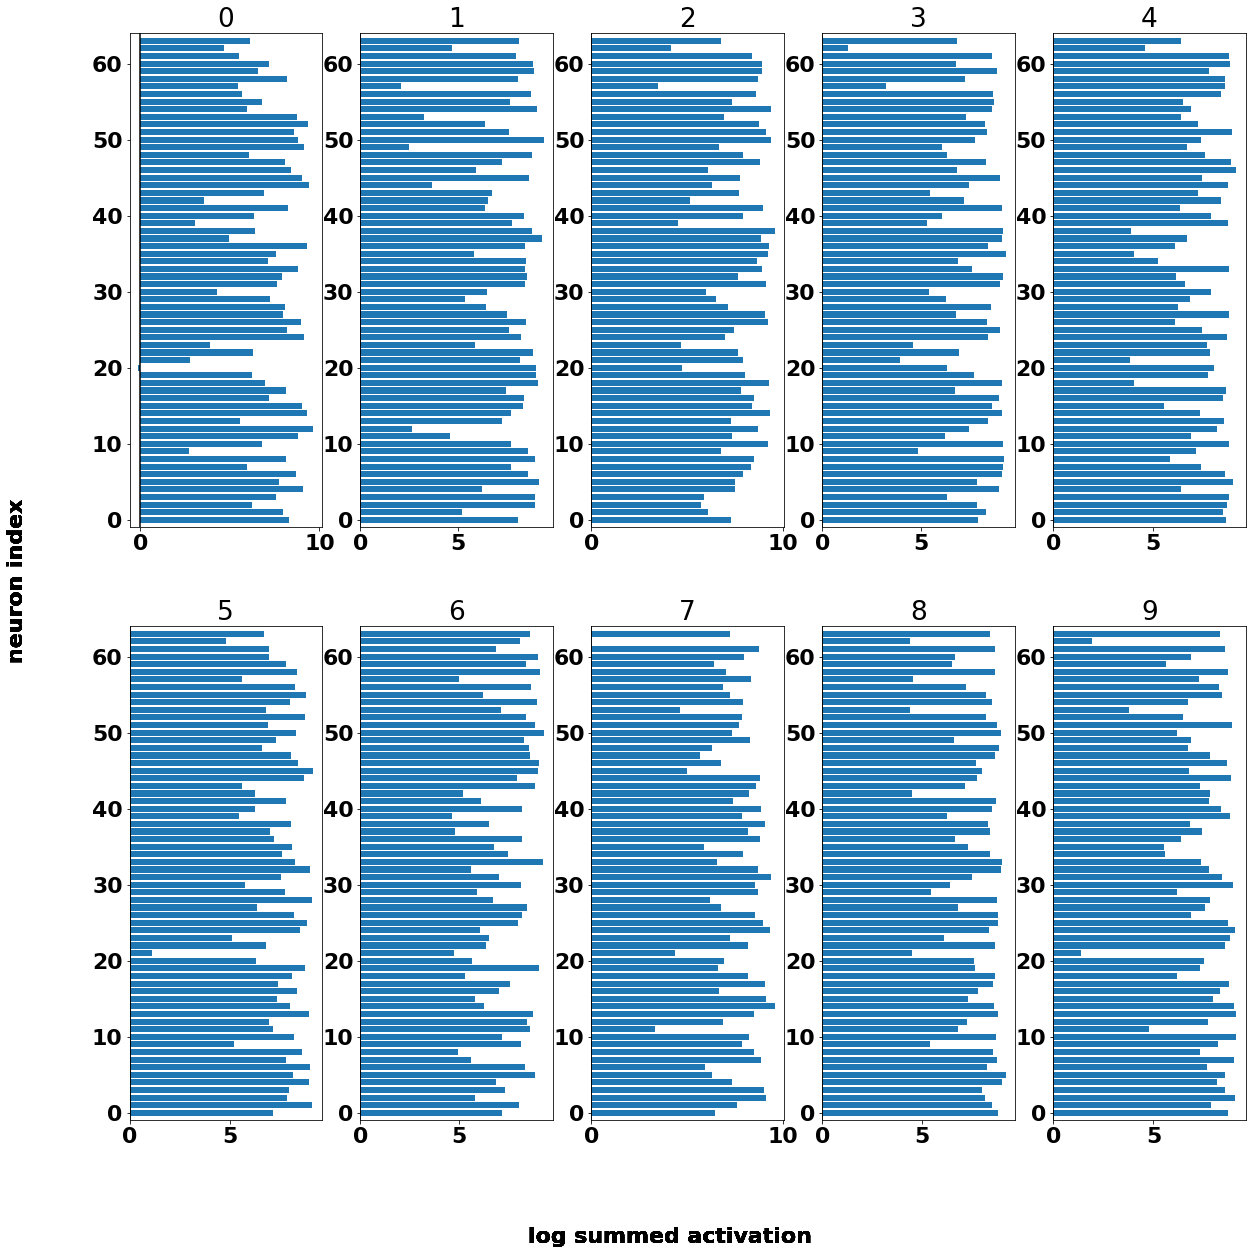

In [27]:
fig = plt.figure(figsize=(20,20))
classes = list(embed2_activations_by_class_test.keys())
classes.sort()
for i,k in enumerate(classes):
    y_pos = np.arange(len(embed2_activations_by_class_test[k]))
    ax = fig.add_subplot(2, 5, i+1)
    ax.set_title(k)
    ax.barh(y_pos, np.log(np.squeeze(embed2_activations_by_class_test[k])), align='center')
    ax.plot([0,0],[-1,len(np.squeeze(embed2_activations_by_class_test[k]))], 'k-')
    ax.set_ylim(-1,len(np.squeeze(embed2_activations_by_class_test[k])))
    fig.text(0.5, 0.04, 'log summed activation', ha='center')
    fig.text(0.04, 0.5, 'neuron index', va='center', rotation='vertical')

### measure degree of polysemantism across training set activations

In [28]:
sum = 0
for c in list(itertools.combinations(range(10), 2)):
    a = (np.squeeze(embed1_activations_by_class[c[0]]) / (np.max(np.abs(np.squeeze(embed1_activations_by_class[c[0]])))) + 1e-9)
    b = (np.squeeze(embed1_activations_by_class[c[1]]) / (np.max(np.abs(np.squeeze(embed1_activations_by_class[c[1]])))) + 1e-9)
    sum += np.dot(np.transpose(a), b)
print(sum/len(list(itertools.combinations(range(10), 2))))

4.725165886349148


In [29]:
sum = 0
for c in list(itertools.combinations(range(10), 2)):
    a = (np.squeeze(embed2_activations_by_class[c[0]]) / (np.max(np.abs(np.squeeze(embed2_activations_by_class[c[0]])))) + 1e-9)
    b = (np.squeeze(embed2_activations_by_class[c[1]]) / (np.max(np.abs(np.squeeze(embed2_activations_by_class[c[1]])))) + 1e-9)
    sum += np.dot(np.transpose(a), b)
print(sum/len(list(itertools.combinations(range(10), 2))))

6.378525405459934


### measure degree of polysemantism across test set activations

In [30]:
sum = 0
for c in list(itertools.combinations(range(10), 2)):
    a = (np.squeeze(embed1_activations_by_class_test[c[0]]) / (np.max(np.abs(np.squeeze(embed1_activations_by_class_test[c[0]])))) + 1e-9)
    b = (np.squeeze(embed1_activations_by_class_test[c[1]]) / (np.max(np.abs(np.squeeze(embed1_activations_by_class_test[c[1]])))) + 1e-9)
    sum += np.dot(np.transpose(a), b)
print(sum/len(list(itertools.combinations(range(10), 2))))

4.770780854754978


In [31]:
sum = 0
for c in list(itertools.combinations(range(10), 2)):
    a = (np.squeeze(embed2_activations_by_class_test[c[0]]) / (np.max(np.abs(np.squeeze(embed2_activations_by_class_test[c[0]])))) + 1e-9)
    b = (np.squeeze(embed2_activations_by_class_test[c[1]]) / (np.max(np.abs(np.squeeze(embed2_activations_by_class_test[c[1]])))) + 1e-9)
    sum += np.dot(np.transpose(a), b)
print(sum/len(list(itertools.combinations(range(10), 2))))

6.646233908335367


### visualise hidden neurons

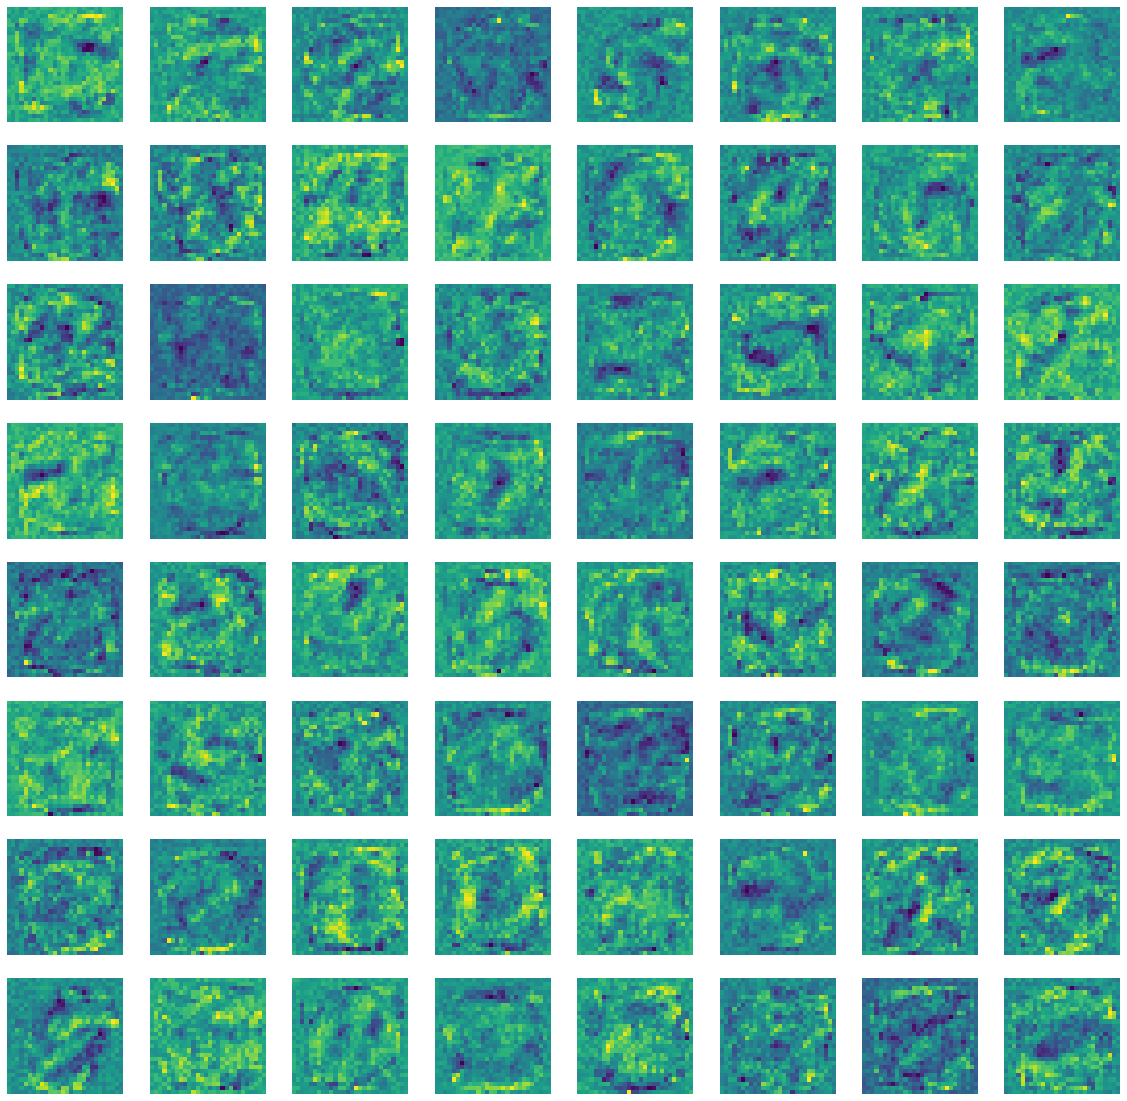

In [32]:
W = model.layers[1].get_weights()
fig = plt.figure(figsize=(20,20))
dim = int(np.ceil(np.sqrt(n_hidden_neurons)))
for j in range(n_hidden_neurons):
    x_j = W[0][:,j] / np.sqrt(np.sum(np.dot(W[0][:,j], W[0][:,j].T)))
    ax = fig.add_subplot(dim,dim,j+1)
    ax.imshow(x_j.reshape((28,28)))
    plt.axis('off')
plt.show()

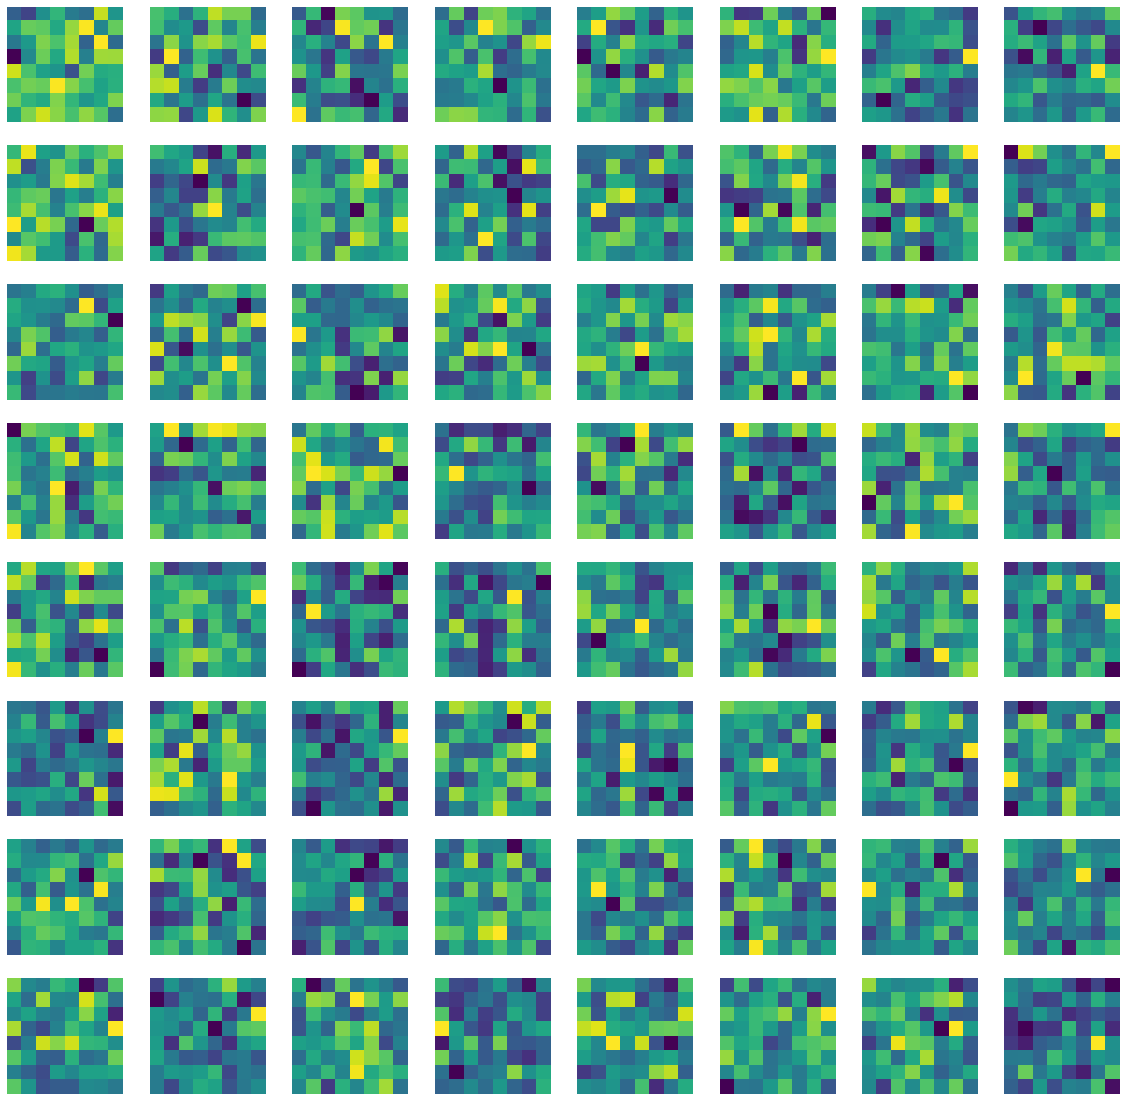

In [33]:
W = model.layers[2].get_weights()
fig = plt.figure(figsize=(20,20))
dim = int(np.ceil(np.sqrt(n_hidden_neurons)))
for j in range(n_hidden_neurons):
    x_j = W[0][:,j] / np.sqrt(np.sum(np.dot(W[0][:,j], W[0][:,j].T)))
    ax = fig.add_subplot(dim,dim,j+1)
    ax.imshow(x_j.reshape((8,8)))
    plt.axis('off')
plt.show()